# **Influence of evolutionary age on the sturctural properties of *de novo* proteins**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp

### Seaborn parameters

In [46]:
palette = ["#43978D", "#8A7090", "#A570FF"]

---

## Define helper functions for plotting

In [47]:
def assign_Age_group(x):
    if x < 5:
        return 1
    elif x < 30:
        return 2
    else:
        return 3

    
def add_medians(ax, df):
    ax.scatter(
        x=[0,1,2], 
        y=[np.nanmedian(df["Young"]), np.nanmedian(df["intermediate"]), np.nanmedian(df["Old"])], 
        marker="d",
        color="k"
    )

def add_stats(ax, df, y=1.05, offset=0.075):

    def stars(p):
        if p < 0.0001:
            return "****"
        elif (p < 0.001):
            return "***"
        elif (p < 0.01):
            return "**"
        elif (p < 0.05):
            return "*"
        else:
            return "n.s."
    
    KruskalResult = kruskal(df["Young"], df["intermediate"], df["Old"], nan_policy="omit")

    print(KruskalResult, "\n")

    if KruskalResult.pvalue < 0.05:
        data = [df["Young"].dropna(), df["intermediate"].dropna(), df["Old"].dropna()]
        dunn = sp.posthoc_dunn(data, p_adjust="Holm")

        print("Dunn-Test: \n", dunn, "\n")

        pval_y_m = dunn[1].iloc[1]
        pval_y_o = dunn[1].iloc[2]
        pval_m_o = dunn[2].iloc[2]

        print("P-Value young vs. intermediate:", pval_y_m)
        print("P-Value young vs. old:", pval_y_o)
        print("P-Value intermediate vs. old:", pval_m_o)

        if stars(pval_y_m) != "n.s.":
            ax.plot([0.05, 0.95], [y, y], lw=0.5, c="k")
            ax.text(0.5, y, stars(pval_y_m), ha="center", va="bottom")
        
        if stars(pval_y_o) != "n.s.":
            ax.plot([0, 2], [y+offset, y+offset], lw=0.5, c="k")
            ax.text(1, y+offset, stars(pval_y_o), ha="center", va="bottom")

        if stars(pval_m_o) != "n.s.":
            ax.plot([1.05, 1.95], [y, y], lw=0.5, c="k")
            ax.text(1.5, y, stars(pval_m_o), ha="center", va="bottom")

---
## Create datasets

In [48]:
dn = pd.read_csv("Data/de_novo_proteins_data.csv", index_col=0)
dn=dn[(dn["mechanism"] == "denovo") | (dn["mechanism"] == "denovo-intron")]
dn["age_group"] = dn["age"].apply(lambda x: assign_Age_group(x))

first_quartile = np.percentile(dn["seqLen"], 25)
second_quartile = np.percentile(dn["seqLen"], 50)
third_quartile = np.percentile(dn["seqLen"], 75)
fourth_quartile = np.percentile(dn["seqLen"], 100)

def assign_length_quartile(length):
    if length <= first_quartile:
        return 1
    elif length <= second_quartile:
        return 2
    elif length <= third_quartile:
        return 3
    else:
        return 4

dn["length_quartile"] = dn["seqLen"].apply(lambda x: assign_length_quartile(x))

dn_young = dn[dn["age_group"] == 1]
dn_medium = dn[dn["age_group"] == 2]
dn_old = dn[dn["age_group"] == 3]

#pLDDT
pLDDT = pd.DataFrame()
pLDDT["Young"] = dn_young["max_pLDDT"]
pLDDT.reset_index(inplace=True, drop=True)
pLDDT["intermediate"] = dn_medium["max_pLDDT"].reset_index(drop=True)
pLDDT["Old"] = dn_old["max_pLDDT"].reset_index(drop=True)

#Alpha-Helices AlphaFold Models
af_alpha = pd.DataFrame()
af_alpha["Young"] = dn_young["alpha_content_AF"]
af_alpha["intermediate"] = dn_medium["alpha_content_AF"].reset_index(drop=True)
af_alpha["Old"] = dn_old["alpha_content_AF"].reset_index(drop=True)

#Beta-Sheets AlphaFold Models
af_beta = pd.DataFrame()
af_beta["Young"] = dn_young["beta_content_AF"]
af_beta["intermediate"] = dn_medium["beta_content_AF"].reset_index(drop=True)
af_beta["Old"] = dn_old["beta_content_AF"].reset_index(drop=True)

# Sequencse lenght
seqlen = pd.DataFrame()
seqlen["Young"] = dn_young["seqLen"]
seqlen["intermediate"]  = dn_medium["seqLen"].reset_index(drop=True)
seqlen["Old"] = dn_old["seqLen"].reset_index(drop=True)

#Diorder predictions - flDPnn
disorder = pd.DataFrame()
disorder["Young"] = dn_young["fraction_disorder_fldpnn"]
disorder["intermediate"] = dn_medium["fraction_disorder_fldpnn"].reset_index(drop=True)
disorder["Old"] = dn_old["fraction_disorder_fldpnn"].reset_index(drop=True)


---
## Plot Comparisons

KruskalResult(statistic=19.335104099389373, pvalue=6.33046324077573e-05) 

Dunn-Test: 
           1         2         3
1  1.000000  0.000482  0.025789
2  0.000482  1.000000  0.125026
3  0.025789  0.125026  1.000000 

P-Value young vs. intermediate: 0.0004819366904300256
P-Value young vs. old: 0.025788654940916738
P-Value intermediate vs. old: 0.12502562196132058


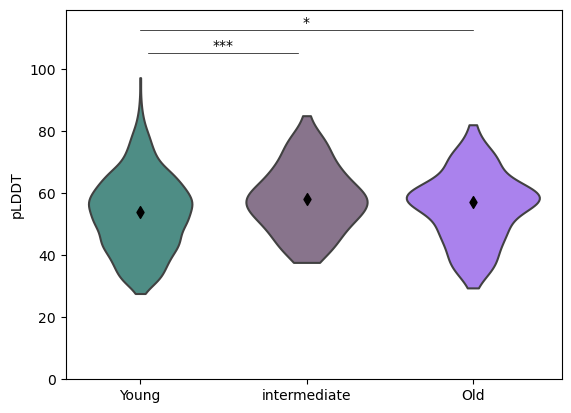

In [49]:
pLDDT_plot = sns.violinplot(data=pLDDT, palette=palette, cut=0, inner=None)


pLDDT_plot.set_ylabel("pLDDT")
pLDDT_plot.set_ylim(0,119)

add_medians(pLDDT_plot, pLDDT)
add_stats(pLDDT_plot, pLDDT, y=105, offset=7.5)


KruskalResult(statistic=0.7183509450246551, pvalue=0.6982518166006513) 



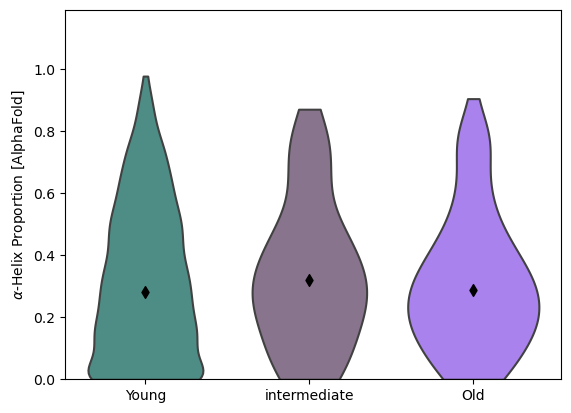

In [50]:
af_alpha_plot = sns.violinplot(data=af_alpha, palette=palette, cut=0, inner=None)

af_alpha_plot.set_ylabel(r"$\alpha$-Helix Proportion [AlphaFold]")
af_alpha_plot.set_ylim(0,1.19)

add_medians(af_alpha_plot, af_alpha)
add_stats(af_alpha_plot, af_alpha)


KruskalResult(statistic=3.6385770743033916, pvalue=0.162141067252913) 



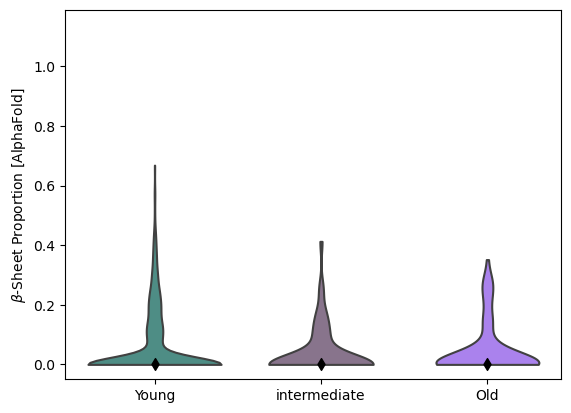

In [51]:
af_beta_plot = sns.violinplot(data=af_beta, palette=palette, cut=0, inner=None)
af_beta_plot.set_ylabel(r"$\beta$-Sheet Proportion [AlphaFold]")
af_beta_plot.set_ylim(-0.05, 1.19)

add_medians(af_beta_plot, af_beta)
add_stats(af_beta_plot, af_beta, y=0.75)


KruskalResult(statistic=49.90277729293461, pvalue=1.4579733813630952e-11) 

Dunn-Test: 
               1         2             3
1  1.000000e+00  0.033516  3.875654e-11
2  3.351557e-02  1.000000  3.351557e-02
3  3.875654e-11  0.033516  1.000000e+00 

P-Value young vs. intermediate: 0.03351556943031621
P-Value young vs. old: 3.875654334782434e-11
P-Value intermediate vs. old: 0.03351556943031621


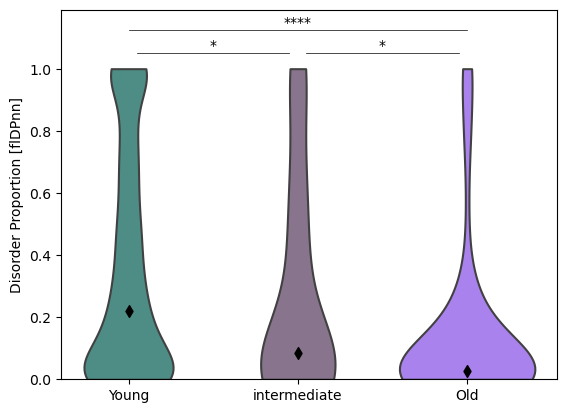

In [52]:
disorder_plot = sns.violinplot(data=disorder, palette=palette, inner=None, cut=0)
disorder_plot.set_ylabel("Disorder Proportion [flDPnn]")
disorder_plot.set_ylim(0, 1.19)

add_medians(disorder_plot, disorder)
add_stats(disorder_plot, disorder)


KruskalResult(statistic=50.77194467475617, pvalue=9.440876057478173e-12) 

Dunn-Test: 
               1             2             3
1  1.000000e+00  1.970511e-02  9.019929e-11
2  1.970511e-02  1.000000e+00  3.673672e-09
3  9.019929e-11  3.673672e-09  1.000000e+00 

P-Value young vs. intermediate: 0.019705114153791083
P-Value young vs. old: 9.019929112713551e-11
P-Value intermediate vs. old: 3.6736721227147564e-09


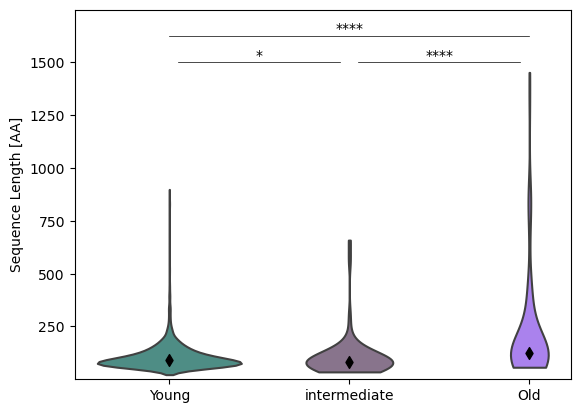

In [57]:
seqlen_plot = sns.violinplot(data=seqlen, palette=palette, inner=None, cut=0)
seqlen_plot.set_ylim(0, 1750)
seqlen_plot.set_ylabel("Sequence Length [AA]")

seqlen_plot.yaxis.set_ticks([250, 500, 750, 1000, 1250, 1500])

add_medians(seqlen_plot, seqlen)
add_stats(seqlen_plot, seqlen, y=1500, offset=125)


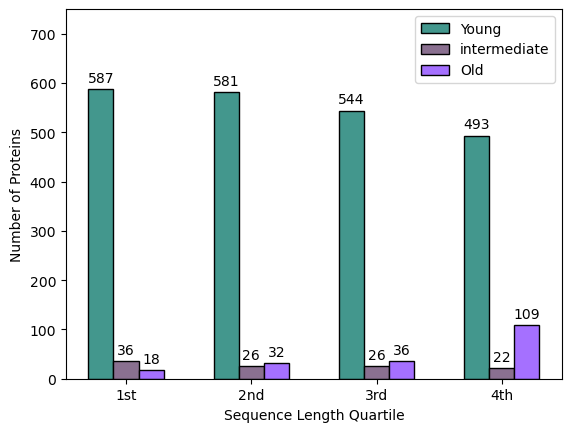

In [58]:
# grouped bar chart of the number of proteins in each age group per lenght quartile

# create a dictionary with the number of proteins in each age group per length quartile

labels = [f"Sequence quartile {i}" for i in range(1,5)]

data = {
    "Young": [len(dn_young[dn_young["length_quartile"] == 1]), len(dn_young[dn_young["length_quartile"] == 2]), len(dn_young[dn_young["length_quartile"] == 3]), len(dn_young[dn_young["length_quartile"] == 4])],
    "intermediate": [len(dn_medium[dn_medium["length_quartile"] == 1]), len(dn_medium[dn_medium["length_quartile"] == 2]), len(dn_medium[dn_medium["length_quartile"] == 3]), len(dn_medium[dn_medium["length_quartile"] == 4])],
    "Old": [len(dn_old[dn_old["length_quartile"] == 1]), len(dn_old[dn_old["length_quartile"] == 2]), len(dn_old[dn_old["length_quartile"] == 3]), len(dn_old[dn_old["length_quartile"] == 4])]
}


x = np.arange(4)
width = 0.2
multiplier = 0

fig, ax = plt.subplots()

for key, value in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, value, width, label=key, color=palette[multiplier], edgecolor="black")
        ax.bar_label(rects, padding=3)
        multiplier += 1

ax.set_ylabel("Number of Proteins")
ax.set_xlabel("Sequence Length Quartile")
ax.set_xticks(x + width, ["1st", "2nd", "3rd", "4th"])

ax.set_ylim(0,750)

ax.legend()

